# Introduction

In this python notebook i will be implementing idea of image captioning which is one of the most intersting problems to solve using deep learning

I will be using Attention mechanism in sequence to sequence model to genrate captions. This idea was first published in [Show and Tell: A Neural Image Caption Generator](https://arxiv.org/abs/1411.4555), 2015.

Let me crack you results of their approch

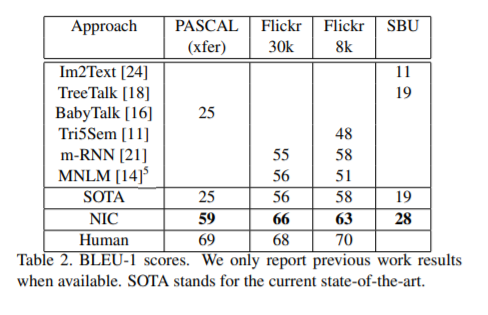

Please Refer paper once

### Load Packages

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import json
import string
import keras
import tensorflow as tf
import pickle
import PIL
import matplotlib.pyplot as plt

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/project-data/image_features_train.json
/kaggle/input/project-data/features.pkl
/kaggle/input/project-data/Flickr_8k.devImages.txt
/kaggle/input/project-data/Flickr8k.lemma.token.txt
/kaggle/input/project-data/Flickr_8k.testImages.txt
/kaggle/input/project-data/train_captions.json
/kaggle/input/project-data/model_17.h5
/kaggle/input/project-data/Flickr8k.token.txt
/kaggle/input/project-data/Flickr_8k.trainImages.txt
/kaggle/input/flickr8k/captions.txt
/kaggle/input/flickr8k/Images/3226254560_2f8ac147ea.jpg
/kaggle/input/flickr8k/Images/214543992_ce6c0d9f9b.jpg
/kaggle/input/flickr8k/Images/2366643786_9c9a830db8.jpg
/kaggle/input/flickr8k/Images/3368819708_0bfa0808f8.jpg
/kaggle/input/flickr8k/Images/2190227737_6e0bde2623.jpg
/kaggle/input/flickr8k/Images/2752809449_632cd991b3.jpg
/kaggle/input/flickr8k/Images/3097776588_312932e438.jpg
/kaggle/input/flickr8k/Images/1206506157_c7956accd5.jpg
/kaggle/input/flickr8k/Images/1319634306_816f21677f.jpg
/kaggle/input/flickr8k/Image

## Photo and Caption Dataset

I am using [Flickr8k Dataset for image captioning.](https://www.kaggle.com/adityajn105/flickr8k). I am not using Big datasets like mscoco-2017 and flickr 8k datasets and many more, because of available resources these big datasets requires high-end computers to train. If you have Computer with good configuration you should definetly try mscoco, i did tried that and end up empty hands after 2 days

This dataset consisting of 8,000 images that are each paired with five different captions which provide clear descriptions of the salient entities and events. The images were chosen from six different Flickr groups, and tend not to contain any well-known people or locations, but were manually selected to depict a variety of scenes and situations


Their measure that can be used to evaluate the skill of the model are BLEU scores. For reference, below are some ball-park BLEU scores for skillful models when evaluated on the test dataset (taken from the 2017 paper [“Where to put the Image in an Image Caption Generator“](https://arxiv.org/pdf/1703.09137.pdf)):

* BLEU-1: 0.401 to 0.578.
* BLEU-2: 0.176 to 0.390.
* BLEU-3: 0.099 to 0.260.
* BLEU-4: 0.059 to 0.170.

I will describe the BLEU metric more later, when i will work on evaluation of model.

Next, let’s look at an example

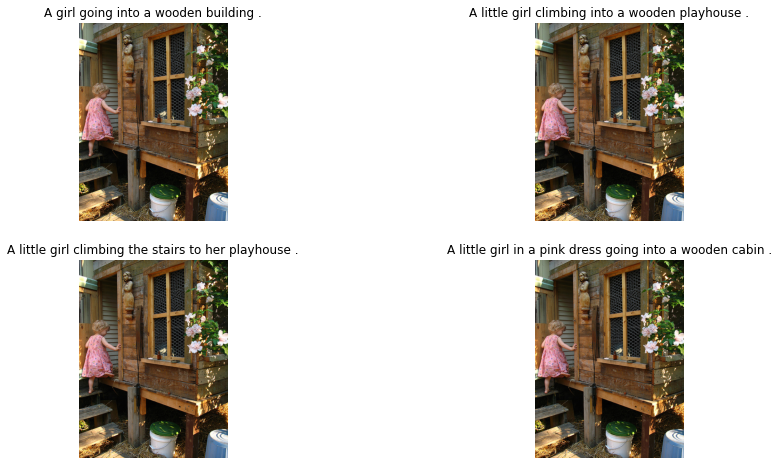

In [2]:
exm_image = PIL.Image.open('../input/flickr8k/Images/1000268201_693b08cb0e.jpg')
exm_image = np.array(exm_image)

exm_captions = ['A child in a pink dress is climbing up a set of stairs in an entry way .',
               'A girl going into a wooden building .',
               'A little girl climbing into a wooden playhouse .',
               'A little girl climbing the stairs to her playhouse .',
               'A little girl in a pink dress going into a wooden cabin .']

plt.figure(figsize = (15,8))
for i in range(1,5):
    ax = plt.subplot(2,2,i)
    ax.imshow(exm_image)
    plt.title(exm_captions[i])
    plt.axis(False)
    

# Prepare Image Data

As discussed in report and paper mentioned above we need to interpret images before pass them to decoder (means convert extract there features) and best method to do this is using CNNs, I will be using VGG16 model to do this task and here i am not going to train VGG16 model will fetch trained one using keras directly (this will make process faster for us)

We can use this model as part of a broader image caption model. The problem is, **it is a large model and running each photo through the network every time we want to test a new language model configuration (downstream) is redundant.**

Instead, we can pre-compute the “photo features” using the pre-trained model and save them to file. We can then load these features later and feed them into our model as the interpretation of a given photo in the dataset. It is no different to running the photo through the full VGG model; it is just we will have done it once in advance.

This is an optimization that will make training our models faster and consume less memory.


We can load the VGG model in Keras using the VGG class. We will remove the last layer from the loaded model, as this is the model used to predict a classification for a photo. We are not interested in classifying images, but we are interested in the internal representation of the photo right before a classification is made. These are the “features” that the model has extracted from the photo.

Keras also provides tools for reshaping the loaded photo into the preferred size for the model (e.g. 3 channel 224 x 224 pixel image).

In [3]:
def extract_features(directory):

    '''
        This function named extract_features() that, given a directory name, 
        will load each photo, prepare it for VGG, and collect the predicted features from the VGG model. 
        The image features are a 1-dimensional 4,096 element vector.
        
        The function returns a dictionary of image identifier to image features.
    '''
    # load the model
    model = keras.applications.vgg16.VGG16()
    
    
    model = keras.models.Model(
        inputs=model.inputs, outputs=model.layers[-2].output)
    
    print(model.summary())
    
    # extracting features from each image
    features = dict()
    for name in os.listdir(directory):
        # load an image from file
        filename = directory + '/' + name
        image = keras.preprocessing.image.load_img(filename, target_size=(224, 224))
        # convert the image pixels to a numpy array
        image = keras.preprocessing.image.img_to_array(image)
        # reshape data for the model
        image = image.reshape(
            (1, image.shape[0], image.shape[1], image.shape[2]))
        # prepare the image for the VGG model
        image = keras.applications.vgg16.preprocess_input(image)
        # get features
        feature = model.predict(image, verbose=0)
        # get image id
        image_id = name.split('.')[0]
        # store feature
        features[image_id] = feature
        print('>%s' % name)
    return features

# extract features from all images
directory = '../input/flickr8k/Images'
features = extract_features(directory)
print('Extracted Features: %d' % len(features))
# save to file
pickle.dump(features, open('features.pkl', 'wb'))

This above mentioned process took aound 3 hours to run and we get 127.12 MB of data in return, saved in directory. Hence we now not need to run it again

# Prepare Text Data

The dataset contains multiple descriptions for each photograph and the text of the descriptions requires some minimal cleaning. First we will read captions file

In [4]:
# Read caption file and store its content into some variable

def load_doc(filename):
    # open the file as read only
    file = open(filename, 'r')
    # read all text
    data = file.read()
    # close the file
    file.close()
    return data

In [5]:
def load_descriptions(doc):
    '''
        Below defines a function load_descriptions() that, given the loaded document text, 
        will return a dictionary of photo identifiers to descriptions. 
        Each photo identifier maps to a list of one or more textual descriptions.
    '''

    mapping = dict()
    # process lines
    for line in doc.split('\n'):
        # split line by white space
        tokens = line.split()
        if len(line) < 2:
            continue
        # take the first token as the image id, the rest as the description
        image_id, image_desc = tokens[0], tokens[1:]
        # remove filename from image id
        image_id = image_id.split('.')[0]
        # convert description tokens back to string
        image_desc = ' '.join(image_desc)
        # create the list if needed
        if image_id not in mapping:
            mapping[image_id] = list()
        # store description
        mapping[image_id].append(image_desc)
    return mapping

Our next step is to create vocabulary(dictonary of words) of all words present in discription data

In [6]:
def to_vocabulary(descriptions):
    # build a list of all description strings
    all_desc = set()
    for key in descriptions.keys():
        [all_desc.update(d.split()) for d in descriptions[key]]
    return all_desc

Now in next step we will clean data. We will clean the text in the following ways in order to reduce the size of the vocabulary of words we will need to work with:

* Convert all words to lowercase.
* Remove all punctuation.
* Remove all words that are one charactered
* Remove all words with numbers in them.

In [7]:
def clean_descriptions(descriptions):
    # prepare translation table for removing punctuation
    table = str.maketrans('', '', string.punctuation)
    for key, desc_list in descriptions.items():
        for i in range(len(desc_list)):
            desc = desc_list[i]
            # tokenize
            desc = desc.split()
            # convert to lower case
            desc = [word.lower() for word in desc]
            # remove punctuation from each token
            desc = [w.translate(table) for w in desc]
            # remove hanging 's' and 'a'
            desc = [word for word in desc if len(word) > 1]
            # remove tokens with numbers in them
            desc = [word for word in desc if word.isalpha()]
            # store as string
            desc_list[i] = ' '.join(desc)

Now lets save discription and image data mappend to each other in directory by file name discription.txt

In [8]:
def save_descriptions(descriptions, filename):
    
    '''Save discription to file with its image identifier'''
    
    lines = list()
    for key, desc_list in descriptions.items():
        for desc in desc_list:
            lines.append(key + ' ' + desc)
    data = '\n'.join(lines)
    file = open(filename, 'w')
    file.write(data)
    file.close()

Link all together

In [9]:
filename = '../input/project-data/Flickr8k.token.txt'
# load descriptions
doc = load_doc(filename)
# parse descriptions
descriptions = load_descriptions(doc)
print('Loaded: %d ' % len(descriptions))
# clean descriptions
clean_descriptions(descriptions)
# summarize vocabulary
vocabulary = to_vocabulary(descriptions)
print('Vocabulary Size: %d' % len(vocabulary))
# save to file
save_descriptions(descriptions, 'descriptions.txt')

Loaded: 8092 
Vocabulary Size: 8763


Till This point we successfully cleaned text data and nicely extract features from image data, now lets move on to next step of defining model

# Model 

First, we must load the prepared photo and text data so that we can use it to fit the model.

In [10]:
# load doc into memory
def load_doc(filename):
    # open the file as read only
    file = open(filename, 'r')
    # read all text
    text = file.read()
    # close the file
    file.close()
    return text

# load a pre-defined list of photo identifiers
def load_set(filename):
    doc = load_doc(filename)
    dataset = list()
    # process line by line
    for line in doc.split('\n'):
        # skip empty lines
        if len(line) < 1:
            continue
        # get the image identifier
        identifier = line.split('.')[0]
        dataset.append(identifier)
    return set(dataset)


# load clean descriptions into memory
def load_clean_descriptions(filename, dataset):
    # load document
    doc = load_doc(filename)
    descriptions = dict()
    for line in doc.split('\n'):
        # split line by white space
        tokens = line.split()
        # split id from description
        image_id, image_desc = tokens[0], tokens[1:]
        # skip images not in the set
        if image_id in dataset:
            # create list
            if image_id not in descriptions:
                descriptions[image_id] = list()
            # wrap description in tokens
            desc = 'startseq ' + ' '.join(image_desc) + ' endseq'
            # store
            descriptions[image_id].append(desc)
    return descriptions

# load photo features
def load_photo_features(filename, dataset):
    # load all features
    all_features = pickle.load(open(filename, 'rb'))
    # filter features
    features = {k: all_features[k] for k in dataset}
    return features


Running below cell first loads the 6,000 photo identifiers in the training dataset. These features are then used to filter and load the cleaned description text and the pre-computed photo features.

In [11]:
# load training dataset (6K)
filename = '../input/project-data/Flickr_8k.trainImages.txt'
train = load_set(filename)
print('Dataset: %d' % len(train))
# descriptions
train_descriptions = load_clean_descriptions('descriptions.txt', train)
print('Descriptions: train=%d' % len(train_descriptions))
# photo features
train_features = load_photo_features('../input/project-data/features.pkl', train)
print('Photos: train=%d' % len(train_features))

Dataset: 6000
Descriptions: train=6000
Photos: train=6000


The description text will need to be encoded to numbers before it can be presented to the model as in input or compared to the model’s predictions.

The first step in encoding the data is to create a consistent mapping from words to unique integer values. Keras provides the Tokenizer class that can learn this mapping from the loaded description data.

In [12]:
# convert a dictionary of clean descriptions to a list of descriptions
def to_lines(descriptions):
    all_desc = list()
    for key in descriptions.keys():
        [all_desc.append(d) for d in descriptions[key]]
    return all_desc

# fit a tokenizer given caption descriptions


def create_tokenizer(descriptions):
    lines = to_lines(descriptions)
    tokenizer = tf.keras.preprocessing.text.Tokenizer()
    tokenizer.fit_on_texts(lines)
    return tokenizer


# prepare tokenizer
tokenizer = create_tokenizer(train_descriptions)
vocab_size = len(tokenizer.word_index) + 1
print('Vocabulary Size: %d' % vocab_size)


Vocabulary Size: 7579


Function below named create_sequences(), given the tokenizer, a maximum sequence length, and the dictionary of all descriptions and photos, will transform the data into input-output pairs of data for training the model. There are two input arrays to the model: one for photo features and one for the encoded text. There is one output for the model which is the encoded next word in the text sequence.

The input text is encoded as integers, which will be fed to a word embedding layer. The photo features will be fed directly to another part of the model. The model will output a prediction, which will be a probability distribution over all words in the vocabulary.

The output data will therefore be a one-hot encoded version of each word, representing an idealized probability distribution with 0 values at all word positions except the actual word position, which has a value of 1.



In [13]:
def max_length(descriptions):
    lines = to_lines(descriptions)
    return max(len(d.split()) for d in lines)

# create sequences of images, input sequences and output words for an image
def create_sequences(tokenizer, max_length, desc_list, photo, vocab_size):
    X1, X2, y = list(), list(), list()
    # walk through each description for the image
    for desc in desc_list:
        # encode the sequence
        seq = tokenizer.texts_to_sequences([desc])[0]
        # split one sequence into multiple X,y pairs
        for i in range(1, len(seq)):
            # split into input and output pair
            in_seq, out_seq = seq[:i], seq[i]
            # pad input sequence
            in_seq = keras.preprocessing.sequence.pad_sequences([in_seq], maxlen=max_length)[0]
            # encode output sequence
            out_seq = keras.utils.to_categorical([out_seq], num_classes=vocab_size)[0]
            # store
            X1.append(photo)
            X2.append(in_seq)
            y.append(out_seq)
    return np.array(X1), np.array(X2), np.array(y)

We have to use progressive loading, to train this model, because if we will use normal approch with which we all are familiar then we need to have 64 to 128 GBs of RAM.

The first step is we must define a function that we can use as the data generator.

We will keep things very simple and have the data generator yield one photo’s worth of data per batch. This will be all of the sequences generated for a photo and its set of descriptions.

The function below data_generator() will be the data generator and will take the loaded textual descriptions, photo features, tokenizer and max length. Here, I assume that you can fit this training data in memory, which I believe 8GB of RAM should be more than capable.

In [14]:
# data generator, intended to be used in a call to model.fit_generator()

def data_generator(descriptions, photos, tokenizer, max_length, vocab_size):
    # loop for ever over images
    while 1:
        for key, desc_list in descriptions.items():
            # retrieve the photo feature
            photo = photos[key][0]
            in_img, in_seq, out_word = create_sequences(
                tokenizer, max_length, desc_list, photo, vocab_size)
            yield [in_img, in_seq], out_word

## Defining Model

We will define a deep learning based on the “merge-model” described by Marc Tanti, et al. in their 2017 papers:

* [Where to put the Image in an Image Caption Generator](https://arxiv.org/abs/1703.09137), 2017.
* [What is the Role of Recurrent Neural Networks (RNNs) in an Image Caption Generator?](https://arxiv.org/abs/1708.02043), 2017.

We will describe the model in three parts:

* Photo Feature Extractor. This is a 16-layer VGG model pre-trained on the ImageNet dataset. We have pre-processed the photos with the VGG model (without the output layer) and will use the extracted features predicted by this model as input.
* Sequence Processor. This is a word embedding layer for handling the text input, followed by a Long Short-Term Memory (LSTM) recurrent neural network layer.
* Decoder (for lack of a better name). Both the feature extractor and sequence processor output a fixed-length vector. These are merged together and processed by a Dense layer to make a final prediction.

The Photo Feature Extractor model expects input photo features to be a vector of 4,096 elements. These are processed by a Dense layer to produce a 256 element representation of the photo.

The Sequence Processor model expects input sequences with a pre-defined length which are fed into an Embedding layer that uses a mask to ignore padded values. This is followed by an LSTM layer with 256 memory units.

Both the input models produce a 256 element vector. Further, both input models use regularization in the form of 50% dropout. This is to reduce overfitting the training dataset, as this model configuration learns very fast.

The Decoder model merges the vectors from both input models using an addition operation. This is then fed to a Dense 256 neuron layer and then to a final output Dense layer that makes a softmax prediction over the entire output vocabulary for the next word in the sequence.

In [15]:
def define_model(vocab_size, max_length):
    # feature extractor model
    inputs1 = keras.layers.Input(shape=(4096,))
    fe1 = keras.layers.Dropout(0.5)(inputs1)
    fe2 = keras.layers.Dense(256, activation='relu')(fe1)
    # sequence model
    inputs2 = keras.layers.Input(shape=(max_length,))
    se1 = keras.layers.Embedding(vocab_size, 256, mask_zero=True)(inputs2)
    se2 = keras.layers.Dropout(0.5)(se1)
    se3 = keras.layers.LSTM(256)(se2)
    # decoder model
    decoder1 = keras.layers.merge.add([fe2, se3])
    decoder2 = keras.layers.Dense(256, activation='relu')(decoder1)
    outputs = keras.layers.Dense(vocab_size, activation='softmax')(decoder2)
    # tie it together [image, seq] [word]
    model = keras.models.Model(inputs=[inputs1, inputs2], outputs=outputs)
    # compile model
    model.compile(loss='categorical_crossentropy', optimizer='adam')
    # summarize model
    model.summary()
    keras.utils.plot_model(model, to_file='model.png', show_shapes=True)
    return model

### Train defined model

In [16]:
# prepare tokenizer
tokenizer = create_tokenizer(train_descriptions)
vocab_size = len(tokenizer.word_index) + 1
print('Vocabulary Size: %d' % vocab_size)
# determine the maximum sequence length
max_len = max_length(train_descriptions)
print('Description Length: %d' % max_len)

# define the model
model = define_model(vocab_size, max_len)
# train the model, run epochs manually and save after each epoch
epochs = 20
steps = len(train_descriptions)
for i in range(epochs):
    # create the data generator
    generator = data_generator(
        train_descriptions, train_features, tokenizer, max_len, vocab_size)
    # fit for one epoch
    model.fit_generator(generator, epochs=1, steps_per_epoch=steps, verbose=1)
    # save model
    model.save('model_' + str(i) + '.h5')


Vocabulary Size: 7579
Description Length: 34
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 34)]         0                                            
__________________________________________________________________________________________________
input_1 (InputLayer)            [(None, 4096)]       0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 34, 256)      1940224     input_2[0][0]                    
__________________________________________________________________________________________________
dropout (Dropout)               (None, 4096)         0           input_1[0][0]                    
_________________________________________________

# Evaluate Model
Once the model is fit, we can evaluate the skill of its predictions on the holdout test dataset.

We will evaluate a model by generating descriptions for all photos in the test dataset and evaluating those predictions with a standard cost function.

First, we need to be able to generate a description for a photo using a trained model.

This involves passing in the start description token ‘startseq‘, generating one word, then calling the model recursively with generated words as input until the end of sequence token is reached ‘endseq‘ or the maximum description length is reached.

In [17]:
# map an integer to a word
def word_for_id(integer, tokenizer):
    for word, index in tokenizer.word_index.items():
        if index == integer:
            return word
    return None

# generate a description for an image


def generate_desc(model, tokenizer, photo, max_len):
    
    '''
        This function generate_desc() implements this behavior and generates a textual description given a trained model,
        and a given prepared photo as input. 
        It calls the function word_for_id() in order to map an integer prediction back to a word.
    '''

    # seed the generation process
    in_text = 'startseq'
    # iterate over the whole length of the sequence
    for i in range(max_len):
        # integer encode input sequence
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        # pad input
        sequence = keras.preprocessing.sequence.pad_sequences([sequence], maxlen=max_len)
        # predict next word
        yhat = model.predict([photo, sequence], verbose=0)
        # convert probability to integer
        yhat = np.argmax(yhat)
        # map integer to word
        word = word_for_id(yhat, tokenizer)
        # stop if we cannot map the word
        if word is None:
            break
        # append as input for generating the next word
        in_text += ' ' + word
        # stop if we predict the end of the sequence
        if word == 'endseq':
            break
    return in_text


We will generate predictions for all photos in the test dataset and in the train dataset.

The function below named evaluate_model() will evaluate a trained model against a given dataset of photo descriptions and photo features. The actual and predicted descriptions are collected and evaluated collectively using the corpus BLEU score that summarizes how close the generated text is to the expected text.

In [18]:
from nltk.translate.bleu_score import corpus_bleu

# evaluate the skill of the model

def evaluate_model(model, descriptions, photos, tokenizer, max_len):
    actual, predicted = list(), list()
    # step over the whole set
    for key, desc_list in descriptions.items():
        # generate description
        yhat = generate_desc(model, tokenizer, photos[key], max_len)
        # store actual and predicted
        references = [d.split() for d in desc_list]
        actual.append(references)
        predicted.append(yhat.split())
    # calculate BLEU score
    print('BLEU-1: %f' % corpus_bleu(actual, predicted, weights=(1.0, 0, 0, 0)))
    print('BLEU-2: %f' % corpus_bleu(actual, predicted, weights=(0.5, 0.5, 0, 0)))
    print('BLEU-3: %f' % corpus_bleu(actual, predicted, weights=(0.3, 0.3, 0.3, 0)))
    print('BLEU-4: %f' % corpus_bleu(actual, predicted, weights=(0.25, 0.25, 0.25, 0.25)))


Evaluation starts...

In [19]:
# load test set
filename = '../input/project-data/Flickr_8k.testImages.txt'
test = load_set(filename)
print('Dataset: %d' % len(test))
# descriptions
test_descriptions = load_clean_descriptions('descriptions.txt', test)
print('Descriptions: test=%d' % len(test_descriptions))
# photo features
test_features = load_photo_features('../input/project-data/features.pkl', test)
print('Photos: test=%d' % len(test_features))

# load the model
filename = '../input/project-data/model_17.h5'
model = keras.models.load_model(filename)
# evaluate model
evaluate_model(model, test_descriptions, test_features, tokenizer, max_len - 1)

Dataset: 1000
Descriptions: test=1000
Photos: test=1000


/opt/conda/lib/python3.7/site-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 4-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)


BLEU-1: 0.506108
BLEU-2: 0.189725
BLEU-3: 0.094747
BLEU-4: 0.140087


# Genrating New Captions


We will generate captions for entirely new photographs in this section.

We also need the Tokenizer for encoding generated words for the model while generating a sequence, and the maximum length of input sequences, used when we defined the model (e.g. 34).

We can hard code the maximum sequence length. With the encoding of text, we can create the tokenizer and save it to a file so that we can load it quickly whenever we need it without needing the entire Flickr8K dataset. An alternative would be to use our own vocabulary file and mapping to integers function during training.

We can create the Tokenizer as before and save it as a pickle file tokenizer.pkl. The complete example is listed below.

In [20]:
# load training dataset (6K)
filename = '../input/project-data/Flickr_8k.trainImages.txt'
train = load_set(filename)
print('Dataset: %d' % len(train))
# descriptions
train_descriptions = load_clean_descriptions('descriptions.txt', train)
print('Descriptions: train=%d' % len(train_descriptions))
# prepare tokenizer
tokenizer = create_tokenizer(train_descriptions)
# save the tokenizer
pickle.dump(tokenizer, open('tokenizer.pkl', 'wb'))

Dataset: 6000
Descriptions: train=6000


We can now load the tokenizer whenever we need it without having to load the entire training dataset of annotations.

Now, let’s generate a description for a new photograph.

In [24]:
# load the tokenizer
tokenizer = pickle.load(open('tokenizer.pkl', 'rb'))
# pre-define the max sequence length (from training)
max_length = 33

In [25]:
filename = '../input/project-data/model_17.h5'
model = keras.models.load_model(filename)

We could do this by re-defining the model and adding the VGG-16 model to it, or we can use the VGG model to predict the features and use them as inputs to our existing model.

In [37]:
# extract features from each photo in the directory
def extract_features_one(filename):
    # load the model
    model = keras.applications.vgg16.VGG16()
    # re-structure the model
    model = keras.models.Model(inputs=model.inputs, outputs=model.layers[-2].output)
    # load the photo
    image = keras.preprocessing.image.load_img(filename, target_size=(224, 224))
    # convert the image pixels to a numpy array
    image = keras.preprocessing.image.img_to_array(image)
    # reshape data for the model
    image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
    # prepare the image for the VGG model
    image = keras.applications.vgg16.preprocess_input(image)
    # get features
    feature = model.predict(image, verbose=0)
    return feature


In [42]:
photo = extract_features_one('../input/flickr8k/Images/103205630_682ca7285b.jpg')
# generate description
description = generate_desc(model, tokenizer, photo, max_length)
print(description)

startseq man is street stands while the another endseq


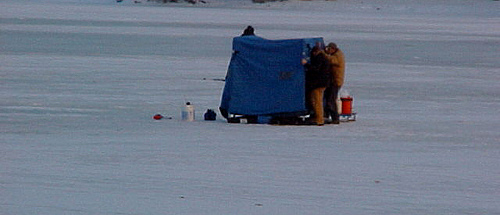

In [41]:
PIL.Image.open('../input/flickr8k/Images/103205630_682ca7285b.jpg')